In [1]:
%matplotlib notebook 
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:

def dist(x1,x2,L):
    """compute the distance between 2 birds whose position vectors are x1 and x2,
        with respect to the periodic boundary condition. L is the length of the square"""
    x=x1[0]
    y=x1[1]
    if abs(x2[0]-x1[0])>L/2:
        x+= np.sign(x2[0]-x1[0])*L 
    x-=x2[0]
    if abs(x2[1]-x1[0])>L/2:
        y+= np.sign(x2[1]-x1[1])*L 
    y-=x2[1]
    d = np.linalg.norm(np.array([x,y]))
    return d


In [3]:
class Flock(object):
    """Represents the N+P-birds configuration at a given moment, in 2D. Birds are flocking in a square of side L
    with periodic boundary conditions. Birds' positions and velocities are contained in two arrays. 
    At t=0, these are pos0 and vel0. The N-first birds are copying other birds just like in Vicsek model. 
    The last P birds are independant, they don't copy others.
    Birds flock will evolve at each time-step Dt"""
    
    def __init__(self,N,P,L,eta,v,r, Dt, pos0, vel0):
        """we choose L as a multiple of r in order to simplify"""
        self.positions = pos0
        self.velocities = vel0
        self.a = int(L/r)
        self.checkering = [[[] for i in range(self.a)] for j in range(self.a)]
        self.eta = eta
        self.v = v
        self.r = r 
        """the interaction radius"""
        self.L = L 
        """the scale of the flock"""
        self.N = N
        self.P = P
        """number of independant birds"""
        self.Dt=Dt
        self.localize_birds()
        
    def localize_birds(self):
        """compute the cell of each bird from its position and actualize self.checkering"""
        self.checkering = [[[] for i in range(self.a)] for j in range(self.a)]
        for k in range ( self.N + self.P):
            i,j = int(self.positions[k][0]/self.r),int(self.positions[k][1]/r)
            self.checkering[i][j].append(k)
        
    
    def compute_new_velocity(self, k):
        """compute the new velocity bird number k will adopt (0<= k <= N, according to the velocity of its neighbours.
        Neighbours are necessary contained in the cell of bird number k and the eight cells around.
        For each of these potential neighbours, we have to check if they are within a circle of radius r around bird number k
        the interaction radius"""
        i,j = int(self.positions[k][0]/self.r),int(self.positions[k][1]/self.r)
        cos_avr = 0
        sin_avr = 0
        for p in range(-1,2):
            for q in range (-1,2):
                for bird in self.checkering[(i+p)%self.a][(j+q)%self.a]:
                    if dist(self.positions[k],self.positions[bird],self.L)<self.r : #check if birds are within a circle of radius r
                        cos_avr += self.velocities[bird,0]
                        sin_avr += self.velocities[bird,1]
        if cos_avr == 0 :
            theta=np.pi+np.sign(sin_avr)*(np.pi)/2
        else :
            theta=np.arctan(sin_avr/cos_avr)
            theta= theta +(1-np.sign(theta)*np.sign(sin_avr))*np.pi/2
        theta+=npr.uniform(-self.eta/2,self.eta/2)
        new_velocity = self.v*np.array([np.cos(theta),np.sin(theta)])
        return new_velocity
    
    def make_step(self):
        """compute the new velocities and positions that birds will get after the time-step,
        actualize self.positions, self.velocities and self.chekering"""
        new_velocities=np.zeros((self.N + self.P,2))
        new_positions=(self.positions).copy()
        for k in range(N):
            new_velocities[k]=self.compute_new_velocity(k)
            new_positions[k]+=(self.velocities[k]*self.Dt)
            new_positions[k]=new_positions[k]%self.L #%L for periodic boundary conditions
        for k in range(N,N+P):
            new_velocities[k]= self.velocities[k]
            new_positions[k]=(self.positions[k]+self.velocities[k]*self.Dt)%self.L
        self.positions = new_positions
        self.localize_birds()
        self.velocities=new_velocities
        
    def compute_avr_norm_velocity(self):
        """compute the average normalized velocity of birds in the flock at time t"""
        va = [0,0]
        for k in range (self.N+self.P):
            va+=self.velocities[k]
        return np.linalg.norm(va/(self.N*self.v))

<IPython.core.display.Javascript object>


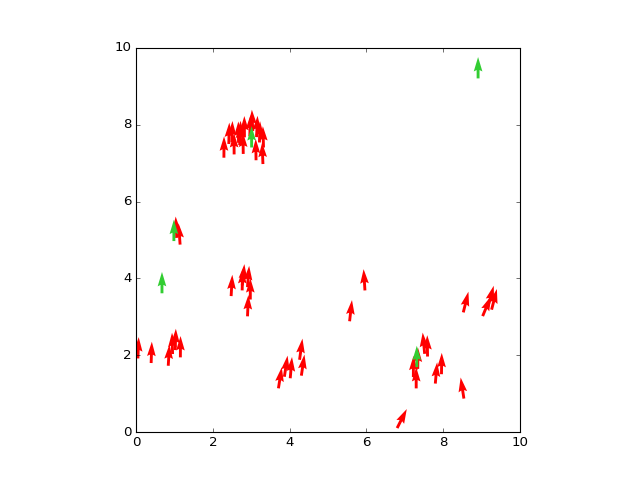

//anaconda/lib/python3.5/site-packages/matplotlib/animation.py:782: UserWarning: MovieWriter writer=ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


In [12]:
#animation of flocking birds ()
N=50
P=5
L=10
R=3
eta=0.1
v=1
r=0.5
Dt=0.3
pos0=npr.uniform(0,L,size=(N+P,2))
theta = npr.uniform(0.,2*np.pi,N+P)
vel0=np.zeros((N+P,2))
vel0[:,0]=v*np.cos(theta)
vel0[:,1]=v*np.sin(theta)
for k in range (N,N+P):
    vel0[k,0]=0
    vel0[k,1]=v
    
fl=Flock(N,P,L,eta,v,r, Dt, pos0, vel0)

#plot within quiver 

X, Y = fl.positions[0:N,0], fl.positions[0:N,1]
U, V = fl.velocities[0:N,0], fl.velocities[0:N,1]
Xl, Yl = fl.positions[N:N+P,0], fl.positions[N:N+P,1]
Ul, Vl = fl.velocities[N:N+P,0], fl.velocities[N:N+P,1]

#fig, ax = plt.subplots(1,1)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
#line, = ax.plot([], [], 'bo', ms=5)
Q = ax.quiver(X, Y, U, V, color='r',)
S = ax.quiver(Xl, Yl, Ul, Vl, color='limegreen',)
ax.set_xlim(0, fl.L)
ax.set_ylim(0, fl.L)

def update_quiver(t):
        fl.make_step()
        X, Y = fl.positions[0:N,0], fl.positions[0:N,1]
        U, V = fl.velocities[0:N,0], fl.velocities[0:N,1]
        Xl, Yl = fl.positions[N:N+P,0], fl.positions[N:N+P,1]
        Ul, Vl = fl.velocities[N:N+P,0], fl.velocities[N:N+P,1]
        Q.set_UVC(U,V)
        Q.set_offsets(np.stack([X,Y],axis =1))
        S.set_UVC(Ul,Vl)
        S.set_offsets(np.stack([Xl,Yl],axis =1))
        return Q, S,

#animation.FuncAnimation(fig, update_quiver, interval=200, blit=False)

anim = animation.FuncAnimation(fig, update_quiver,
                               interval=500, frames=1000, blit=False)
anim.save("vicsek_leaders_on_line.mp4","writer=ffmpeg")

In [ ]:
#normalized velocity dependance within time. 
#We would like to know how many steps are necessary to stabilize the normalized average velocity va

N=200
L=10
eta=np.pi/10
v=0.1
r=1.
Dt=1.
pos0=npr.uniform(0,L,size=(N,2))
theta = npr.uniform(0.,2*np.pi,N)
vel0=np.zeros((N,2))
vel0[:,0]=v*np.cos(theta)
vel0[:,1]=v*np.sin(theta)
fl2=Flock(N,L,eta,v,r, Dt, pos0, vel0)
L=[]
T=[]
t=0
for i in range(2000):
    T.append(t)
    fl2.make_step()
    L.append(fl2.compute_avr_norm_velocity())
    t+=1

plt.figure()
plt.plot(T,L)

In [ ]:
Dt=1.
v=0.1
r=1.
N=300
L=4.
eta = 0.5

def generate_random_flock(N, L, eta, v, r, Dt):
    pos0=npr.uniform(0,L,size=(N,2))
    theta = npr.uniform(0.,2*np.pi,N)
    vel0=np.zeros((N,2))
    vel0[:,0]=v*np.cos(theta)
    vel0[:,1]=v*np.sin(theta)
    fl=Flock(N,L,eta,v,r, Dt, pos0, vel0)
    return fl

eta = np.linspace(0,3,25)
eta = eta.tolist()
eta_2= np.linspace(3,6,50)
eta_2 = eta_2.tolist()
eta+= eta_2
    
def noise_influence():
    noise_influence = open("noise_influenceL=4.txt","w")
    for et in eta:
        va = 0
        var = 0
        for n in range (10):
            fl = generate_random_flock(N, L, et, v, r, Dt)
            for k in range(150):
                fl.make_step()
            va+=fl.compute_avr_norm_velocity()
            var+=(fl.compute_avr_norm_velocity())**2
        va/=10
        sigma= np.sqrt((var/10)-(va)**2)
        noise_influence.write("\n" +str(et)+" "+str(va)+" "+str(sigma))
    noise_influence.close()  
    
#noise_influence()

"""#à mettre dans analysis
M = np.loadtxt("noise_influenceL=4.txt")
Noise = M[:,0]
V_n = M[:,1]
Sigma_n = M[:,2]
        
#à mettre dans analysis       
noise_fig = plt.figure()
plt.plot(Noise, V_n)
plt.errorbar(Noise, V_n, yerr=Sigma_n, fmt='o')
plt.title('Noise influence on v_a')
"""


In [ ]:
"""#order parameter dependance within N vectorized
N0= [8,10,12,14,16,20]
theta1 = [npr.uniform(0.,2*np.pi,n) for n in N0]
vel01=[np.zeros((n,2)) for n in N0]
vel01[:,0]=v*np.cos(theta1)
vel01[:,1]=v*np.sin(theta1)
flockN = [Flock(N1, L, eta, v, r, Dt, npr.uniform(0,L,size=(N1,2)), np.zeros((N1,2))) for N1 in N0]
for i in range(10):
    for fl1 in flockN:
        fl1.make_step()
avg_vel_N =[fl1.compute_avr_velocity() for fl1 in flockN]
plt.xlabel("N")
plt.ylabel("order parameter")
plt.plot(N0,avg_vel_N,color="red")
plt.savefig("order parameter dependance within density")"""

In [ ]:
#order parameter dependance within N non vectorized
